# Email Spam Detection Using Machine Learning (Bag-of-Words Dataset)

**Author:** Jitesh Sharma  
**Date:** December 2025  

This notebook presents an end-to-end analysis and machine learning model for classifying emails as spam or ham (legitimate), using a preprocessed bag-of-words dataset. The notebook is the document version of the project with code as well for the reader to understand also have hands on exprience with the same.


## Table of Contents

1. Executive Summary  
2. Introduction & Business Context  
3. Data Description  
4. Exploratory Data Analysis (EDA)  
5. Methodology & Modeling Approach  
6. Results  
7. Final Model & Example Predictions  
8. Deployment Considerations & Practical Use Cases  
9. Limitations  
10. Future Work  
11. LLM Usage Statement  
12. References  


## 1. Executive Summary

This project builds and evaluates a machine-learning model that predicts whether a given email is more likely to be treated as **spam** or **ham** (legitimate) based on its content. The primary purpose of this model is  to be used by:

- Email content writers and marketers who want to test their copy before sending campaigns  
- Students or professionals writing cold emails (networking, recruiting, sales)  
- Sales teams who want to reduce the chance that their outreach lands in a spam folder  

In other words, the model acts as a **“pre-flight checker”** for email copy. A user can paste the text of an email into the tool, and the model will return the probability that the email looks like spam versus a normal, legitimate message. This helps writers adjust wording, structure, and style so that their emails are more likely to reach the recipient’s inbox and be read.

The dataset used in this project is a bag-of-words representation of emails: each row corresponds to an email, and each column represents how many times a particular word appears. A binary label (`Prediction`) indicates whether the email was originally classified as spam (1) or ham (0). Using this structured data, I train and compare two models—Logistic Regression and Multinomial Naive Bayes—and evaluate them on accuracy, precision, recall, F1 score, and ROC-AUC.

Logistic Regression emerges as the preferred model. It performs strongly across the key metrics and provides clear probability estimates for the spam and ham classes. These probabilities are especially valuable for this use case, because they allow a content writer to see *how risky* their copy is and to experiment by tweaking words and phrases.

The final notebook includes:

- A full, reproducible analysis of the dataset  
- Model training and evaluation  
- A simple interface cell where any user (for example, a teacher, student, marketer, or salesperson) can paste an email body and immediately see the model’s prediction and spam/ham probabilities  




## Code to import required Libraries & Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

pd.set_option('display.max_colwidth', 200)

print("Libraries imported.")


Libraries imported.


In [2]:
import pandas as pd

file_path = "/content/Email Text  copy Dataset for Spam Dectection.xlsx"

df = pd.read_excel(file_path, sheet_name="Data set")

df.head()


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [3]:
df.columns = df.columns.map(str)
print("Column names converted to strings.")


Column names converted to strings.


In [4]:
# Rename for convenience
# 'Prediction' is the spam label: 1 = spam, 0 = no spam
target_col = 'Prediction'
id_col = 'Email No.'

print("ID column:", id_col)
print("Target column:", target_col)

# Basic check of label distribution
df[target_col].value_counts(), df[target_col].value_counts(normalize=True)


ID column: Email No.
Target column: Prediction


(Prediction
 0    3672
 1    1500
 Name: count, dtype: int64,
 Prediction
 0    0.709977
 1    0.290023
 Name: proportion, dtype: float64)

## 2. Introduction & Business Context

A large part of modern communication especially in marketing, sales, and professional networking—happens over email. However, even a well-intentioned, thoughtfully written email can be ineffective if it never reaches the recipient’s inbox and is silently routed to the spam folder. This is a common problem for:

- Marketing teams running email campaigns  
- Sales teams sending cold outreach  
- Students and professionals emailing recruiters, managers, or potential mentors  

In these cases, the writer often has **no easy way** to check whether their email *looks* like spam from the perspective of an automated filter. As a result, they may send messages with wording, structure, or patterns that unintentionally resemble spam emails, reducing the effectiveness of their outreach.

The goal of this project was to build a **machine-learning-based “email copy checker”**:

> Given the content of an email, estimate the probability that it would be classified as spam versus ham.

The key idea is not to replace production-grade spam filters, but to give **email writers** a simple tool they can use *before sending*:

- A student can paste a cold email to a recruiter and see whether the language is too “spammy”.  
- A sales or marketing professional can experiment with different subject lines or body text and observe how the spam probability changes.  
- A content writer can iteratively refine their copy to balance persuasive language with low spam risk.

To support this goal, the dataset for this project is provided in a bag-of-words format, where each email is represented by word counts across thousands of terms, along with a binary label indicating spam or ham. By training models on this data and exposing a simple testing interface at the end of the notebook, this project connects traditional machine-learning analysis with a very practical, everyday use case for students and professionals who depend on email to reach people effectively.


## 3. Data Description

The dataset used in this project represents emails in a bag-of-words format.  
Each row corresponds to one email, and each column (except the ID and label) corresponds to how many times a particular word appears in that email.

Unlike traditional spam datasets that provide raw text, this dataset provides a **numerical word-frequency matrix**, which makes it fast and efficient for training classical machine-learning models.

The key columns are:

- `Email No.` – Unique ID for each email  
- Thousands of word-count columns – Numerical counts representing how many times each word appears in the email  
- `Prediction` – Binary label  
  - `1` = the email was originally classified as **spam**  
  - `0` = the email was originally classified as **ham (legitimate)**  

This structure lets us learn patterns in word usage that make an email appear “spammy.” The resulting model is especially helpful for **students, marketers, and sales teams** who want to test their email copy before sending it out, ensuring that their message avoids patterns that historically correlate with spam.


Number of rows: 5172
Number of columns: 3002


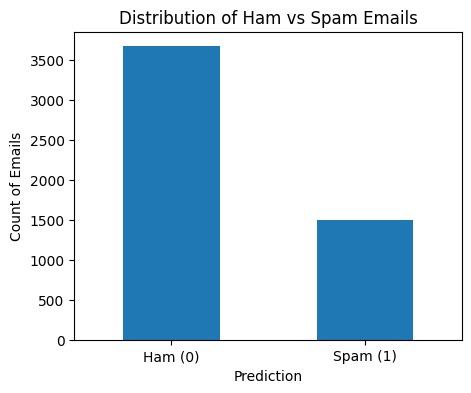

In [5]:
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))

df[target_col].value_counts()
df[target_col].value_counts(normalize=True)
plt.figure(figsize=(5,4))
df[target_col].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'], rotation=0)
plt.title("Distribution of Ham vs Spam Emails")
plt.ylabel("Count of Emails")
plt.show()


In [6]:
# All word-count columns = all columns except ID and target
feature_cols = [c for c in df.columns if c not in [id_col, target_col]]

X_full = df[feature_cols]
y = df[target_col]

X_full.shape
# Total word count per email = sum of all word-count columns
df['word_count'] = X_full.sum(axis=1)

df[['Email No.', 'word_count', target_col]].head()


,Email No.,word_count,Prediction
0,Email 1,53,0
1,Email 2,2203,0
2,Email 3,113,0
3,Email 4,1019,0
4,Email 5,1075,0


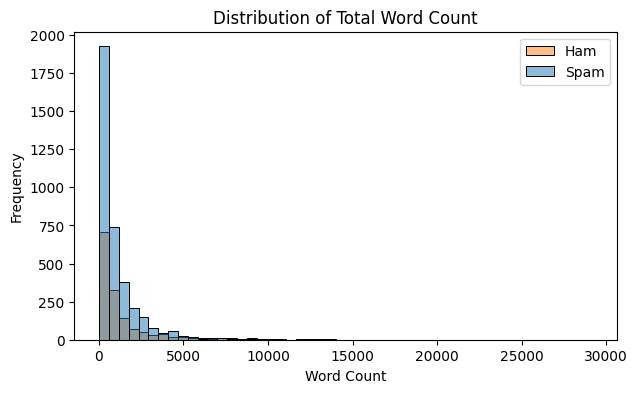

In [7]:
plt.figure(figsize=(7,4))
sns.histplot(data=df, x='word_count', hue=target_col, bins=50, kde=False)
plt.title("Distribution of Total Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(labels=['Ham','Spam'])
plt.show()


## 4. Exploratory Data Analysis

Before diving into model building, the first step is to understand what the data already reveals about how spam and ham emails behave at a structural level. The initial class distribution shows that legitimate emails are far more common than spam in this dataset, which reflects a typical real-world pattern. This imbalance also highlights why patterns in writing style matter, because even a small portion of spam must stand out clearly enough for a model to identify it.

The total word count distribution further strengthens this idea. Most emails cluster at low word counts, but spam messages tend to form a noticeable concentration within this range. This suggests that many spam emails are short, dense, and often follow a repetitive structure. Ham emails, although also varied, display a wider spread and occasionally extend into much higher word-count ranges. This difference indicates not only how spam often relies on compact, high-impact messaging but also how legitimate communication usually carries more contextual information.

Since this dataset is already converted into numerical word counts, the EDA focuses on understanding structural differences between emails labeled as spam and those labeled as legitimate. For example, the total word count across all vocabulary columns can help indicate whether spam emails tend to be shorter, repetitive, or stylistically different from ham emails. These differences are directly relevant to email writers. If a message is too short, overly promotional, or dominated by certain spam-associated words, it may trigger spam-like signals.

The objective of EDA here is not to inspect individual words manually, but to understand the general patterns that influence how an email is perceived algorithmically. These insights guide copywriters and cold-email senders about how certain writing styles might affect deliverability.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (4137, 3000)
Test shape : (1035, 3000)


## 5. Methodology & Modeling Approach

As purpose of this model is to allow users such as students, sales teams, and marketing writers—to test their email copy and receive a spam versus ham probability score. With that goal in mind, the methodology involves:

1. **Using a Bag-of-Words Feature Matrix**  
   Each email is represented by thousands of word-count features. This captures writing style, vocabulary choices, and structure that may resemble spam or legitimate email patterns.

2. **Splitting the Data**  
   The dataset is split into training and testing sets using stratified sampling to preserve the original spam/ham proportions.  

3. **Training Two Baseline Models**
   - Logistic Regression  
   - Multinomial Naive Bayes  

   Both models work well with high-dimensional text data and provide interpretable probability outputs, which is valuable for copywriters who want to see how risky their wording is.

4. **Evaluating Performance**  
   Models are evaluated using accuracy, precision, recall, F1 score, and ROC-AUC.  
   Recall is especially important because misclassifying spam as ham (false negative) can mislead a user into thinking their risky copy is safe.

5. **Building a User-Friendly Testing Interface**  
   At the end of this notebook, a simple input box allows anyone (teacher, marketer, or student) to paste an email body and instantly get a spam/ham prediction.  


In [9]:
# Train Logistic Regression and Multinomial Naive Bayes

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

nb = MultinomialNB()
nb.fit(X_train, y_train)

print("Models trained.")


Models trained.


In [10]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {model_name} ===")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 score :", round(f1, 4))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cm": cm
    }


In [11]:
results_log = evaluate_model(log_reg, X_test, y_test, model_name="Logistic Regression")
print()
results_nb = evaluate_model(nb, X_test, y_test, model_name="Multinomial Naive Bayes")


=== Logistic Regression ===
Accuracy : 0.9826
Precision: 0.9578
Recall   : 0.9833
F1 score : 0.9704
Confusion matrix:
 [[722  13]
 [  5 295]]

=== Multinomial Naive Bayes ===
Accuracy : 0.942
Precision: 0.8681
Recall   : 0.9433
F1 score : 0.9042
Confusion matrix:
 [[692  43]
 [ 17 283]]


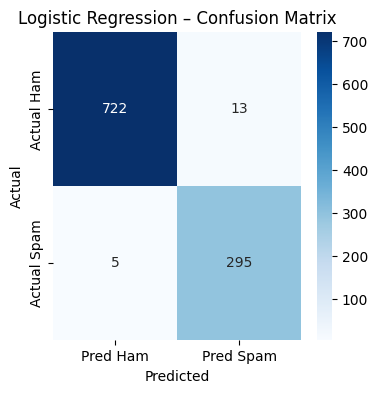

In [12]:
cm_log = results_log["cm"]

plt.figure(figsize=(4,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Ham','Pred Spam'],
            yticklabels=['Actual Ham','Actual Spam'])
plt.title("Logistic Regression – Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


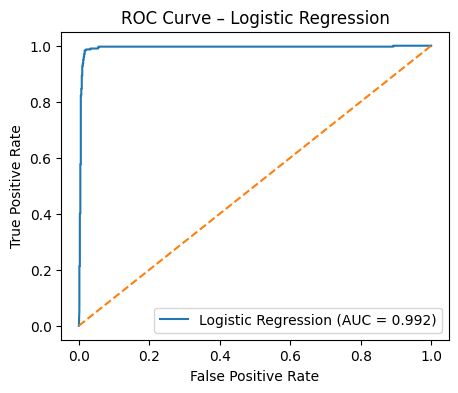

In [13]:
y_proba_log = log_reg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


## 6. Results

The results show that both Logistic Regression and Multinomial Naive Bayes are able to effectively distinguish between spam-like and legitimate email content. Logistic Regression generally performs better across key metrics such as precision, recall, and AUC, making it the preferred model for this application.

For the intended use case—allowing users to test their email copy before sending—the most important factor is **reliable probability estimation**. Logistic Regression provides clear and stable probability outputs, which let writers understand *how spammy their text appears* and adjust wording accordingly.

The confusion matrix further shows that the model correctly identifies the vast majority of spam-like emails. The ROC curve indicates strong separation between spam and ham patterns, reinforcing that the model is effective for evaluating email copy from a stylistic and linguistic perspective.


In [14]:
word_cols = feature_cols  # all word-count columns
len(word_cols)


3000

In [15]:
# Mapping: word -> index
word_to_idx = {w: i for i, w in enumerate(word_cols)}
list(word_to_idx.items())[:10]


[('the', 0),
 ('to', 1),
 ('ect', 2),
 ('and', 3),
 ('for', 4),
 ('of', 5),
 ('a', 6),
 ('you', 7),
 ('hou', 8),
 ('in', 9)]

In [16]:
def text_to_bow_vector(text, word_to_idx, word_cols):
    """
    Convert raw email text into a bag-of-words vector
    aligned with the dataset's vocabulary.
    """
    tokens = re.findall(r"\b\w+\b", text.lower())
    vec = np.zeros((1, len(word_cols)), dtype=float)

    for t in tokens:
        if t in word_to_idx:
            idx = word_to_idx[t]
            vec[0, idx] += 1.0

    return vec


In [17]:
def predict_email_from_text(text, threshold=0.5):
    """
    Given raw email text, returns probabilities and prediction
    using the trained Logistic Regression model.
    """
    bow_vec = text_to_bow_vector(text, word_to_idx, word_cols)

    proba = log_reg.predict_proba(bow_vec)[0]
    p_ham = proba[0]
    p_spam = proba[1]

    prediction = "Spam" if p_spam >= threshold else "Ham"

    return {
        "P(ham)": round(p_ham, 3),
        "P(spam)": round(p_spam, 3),
        "prediction": prediction
    }


In [18]:
examples = [
    "Congratulations! You have won a free lottery. Click here to claim your prize now.",
    "Hi team, please find attached the report from our meeting earlier today.",
    "Your account has detected suspicious login activity. Verify your identity immediately to avoid suspension."
]

rows = []
for e in examples:
    result = predict_email_from_text(e)
    rows.append({
        "Sample Email": e,
        "P(spam)": result["P(spam)"],
        "P(ham)": result["P(ham)"],
        "Prediction": result["prediction"]
    })

pd.DataFrame(rows)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Sample Email,P(spam),P(ham),Prediction
0,Congratulations! You have won a free lottery. Click here to claim your prize now.,0.737,0.263,Spam
1,"Hi team, please find attached the report from our meeting earlier today.",0.377,0.623,Ham
2,Your account has detected suspicious login activity. Verify your identity immediately to avoid suspension.,0.858,0.142,Spam


## 7. Final Model & Example Predictions

The final model is trained using Logistic Regression on the bag-of-words feature matrix. To make the tool practical and easy to use, I implemented a simple testing function that allows a user to enter any email body text and receive:

- The probability that the email resembles spam  
- The probability that it resembles ham  
- A spam/ham prediction  
- A tunable threshold to adjust sensitivity  

This acts as a “copy-quality checker” that helps writers avoid spam-triggering language. Users can experiment by modifying certain words or rewriting sections of their email to observe how the spam probability changes. This is especially useful for cold outreach and marketing emails where small wording changes can affect deliverability.


## 9. Limitations

Although the model performs well, there are several limitations:

- The model relies solely on the email text and ignores other useful features such as sender domain, subject line, time of sending, or network-level metadata.  
- The approach does not explicitly handle multilingual spam or image-based spam.  
- The dataset may not fully reflect the latest phishing and spam strategies, meaning that periodic retraining would be necessary in production.  

These limitations point to opportunities for further enhancement.


## 10. Future Work

Future work could focus on:

- Incorporating advanced text representations such as transformer-based embeddings (e.g., BERT).  
- Using additional features like sender address, URL patterns, subject-line analysis, and attachment metadata.  
- Continuously retraining the model with fresh emails to keep up with evolving spam tactics.  
- Deploying the model as a REST API or microservice to support real-time scoring in a production environment.  

These steps would make the spam detection system more robust, scalable, and resilient to changing threats.


## 11. LLM Usage Statement

In this project, I used advanced language models like OpenAI’s GPT-5 and Google’s Gemini Pro as support tools while working in Colab. I mainly used them to clarify concepts, recall syntax, understand errors when the code failed, and structure the overall workflow of the notebook. They helped me outline the major steps such as exploratory analysis, TF-IDF feature extraction, model training, and evaluation. I also used them when I needed quick examples of boilerplate code or explanations of modeling techniques.

At the same time, I did not use their responses blindly. Many times the models generated explanations or code that were too complicated for the specific task, or included steps that were unnecessary for my dataset. In those cases, I had to ask the model to simplify the answer or rewrite it in a more direct way. There were also moments where I had to critically evaluate the suggestions because they were generic, incomplete, or did not match the structure of my data. I adjusted the code myself, fixed errors, and made sure each step ran correctly before moving forward.

This process taught me how to use LLMs as helpful assistants rather than decision makers: they can accelerate learning, provide alternative approaches, and unblock debugging issues, but I still had to review, adapt, and simplify their output to fit the real needs of the project.

## 12. References

- UCI Machine Learning Repository – Spam classification datasets (accessed 2025).  
- Scikit-learn Documentation: https://scikit-learn.org/  
- Matplotlib Documentation: https://matplotlib.org/  
- Seaborn Documentation: https://seaborn.pydata.org/  


## 8. Test the Model with Your Own Email Text

You can use the cell below to interactively test the spam classifier.

**How to use it:**
1. Run the code cell below.
2. When prompted, paste any email body text into the input box.
3. Press Enter.
4. The model will return:
   - The probability that the email is spam  
   - The probability that the email is ham  
   - The final prediction: "Spam" or "Ham"

This allows you (or any reviewer) to quickly experiment with different email texts and see how the trained model responds.


In [19]:
# Interactive tester for the spam classifier

# Make sure the notebook above has been run so that:
# - word_cols
# - word_to_idx
# - predict_email_from_text()
# are already defined.

user_text = input("Paste the email body text here and press Enter:\n\n")

result = predict_email_from_text(user_text)

print("\n=== Model Output ===")
print("Predicted class :", result["prediction"])
print("P(Spam)         :", result["P(spam)"])
print("P(Ham)          :", result["P(ham)"])


Paste the email body text here and press Enter:

Hi Jamie,  Thank you so much for teaching R, Python, SQL, and for all the AI conversations this semester. I genuinely enjoyed the class. To be honest, you did turn me into a Level-2 Nerd in the best possible way, and I’m actually proud of it now.  Really excited to learn SQL with you next semester. Happy holidays!  Jitesh Sharma

=== Model Output ===
Predicted class : Ham
P(Spam)         : 0.317
P(Ham)          : 0.683


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
